In [1]:
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from plotter import Plotter
import dolfin as df
from ffian.project_flow_models import ModelMC1, ModelMC2, ModelMC3, ModelMC4, ModelMC5
import inspect

%matplotlib inline

In [17]:
class PlotObject:
    def __init__(self, model_v, n=None):
        with open(f'results/stimulation_data/timedata/{model_v}.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
            if model_v == 'MC3' or model_v == 'MC5':
                [j_ins, j_decs, dalpha_is, dalpha_es, 
                 Na_is, Na_es, K_is, K_es, Cl_is, Cl_es, HCO3_is, HCO3_es, 
                 p_ms, phi_ms, j_pumps] = pickle.load(f)
                self.HCO3_is = HCO3_is
                self.HCO3_es = HCO3_es
            else:
                [j_ins, j_decs, dalpha_is, dalpha_es, 
                 Na_is, Na_es, K_is, K_es, Cl_is, Cl_es, 
                 p_ms, phi_ms, j_pumps] = pickle.load(f)
            self.j_in = j_ins
            self.j_dec = j_decs
            self.dalpha_i = dalpha_is
            self.dalpha_e = dalpha_es
            self.Na_i = Na_is
            self.Na_e = Na_es
            self.K_i = K_is
            self.K_e = K_es
            self.Cl_i = Cl_is
            self.Cl_e = Cl_es
            self.p_m = p_ms
            self.phi_m = phi_ms
            self.j_pump = j_pumps
            
        j_in = 1.0e-6                # input constant (mol/(m^2s))
        Tstop = 60                   # duration of simulation (s)
        stim_start = 10              # stimulus onset (s)
        stim_end = 20                # stimulus offset (s)
        if n is None:
            n = stim_end
        stim_protocol = 'constant'   # stimulus protocol ('constant', 'slow', or 'ultraslow')
        # mesh
        N = 400                                  # mesh size
        L = 3.0e-4                               # m (300 um)
        mesh = df.IntervalMesh(N, 0, L)          # create mesh

        # time variables
        dt_value = 1e-3                          # time step (s)

        # model setup
        t_PDE = df.Constant(0.0)  # time constant
        class_name = f"Model{model_v}"
        if class_name in globals() and inspect.isclass(globals()[class_name]):
            model_type = globals()[class_name]
        model = model_type(model_v, mesh, L, t_PDE, j_in, stim_start, stim_end, stim_protocol)
        
        path_data = 'results/data/' + model_v + '/'
        path_figs = 'results/figures/'
        P = Plotter(model, path_data)
        
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']
        alpha_i_init = float(model.alpha_i_init)
        alpha_e_init = float(model.alpha_e_init)

        # get data
        alpha_i_ = P.read_from_file(n, 0)
        Na_i_ = P.read_from_file(n, 1)
        Na_e_ = P.read_from_file(n, 2)
        K_i_ = P.read_from_file(n, 3)
        K_e_ = P.read_from_file(n, 4)
        Cl_i_ = P.read_from_file(n, 5)
        Cl_e_ = P.read_from_file(n, 6)
        if model_v == 'MC3' or model_v == 'MC5':
            HCO3_i_ = P.read_from_file(n, 7)
            HCO3_e_ = P.read_from_file(n, 8)
            phi_i_ = P.read_from_file(n, 9)
            phi_e_ = P.read_from_file(n, 10)
        else:
            phi_i_ = P.read_from_file(n, 7)
            phi_e_ = P.read_from_file(n, 8)

        # calculate extracellular volume fraction
        alpha_e_ = 0.6 - alpha_i_

        # get input/decay fluxes
        j_in_ = model.j_in(n)
        j_dec_ = model.j_dec(K_e_)

        # calculate transmembrane hydrostatic pressure
        tau = K_m*(alpha_i_ - alpha_i_init)
        p_m = tau + p_m_init

        # calculate membrane potential
        phi_m_ = (phi_i_ - phi_e_)*1000  # convert to mV

        # changes from baseline
        dalpha_i_ = (alpha_i_ - alpha_i_init)/alpha_i_init*100
        dalpha_e_ = (alpha_e_ - alpha_e_init)/alpha_e_init*100
        dNa_i_ = Na_i_ - float(model.Na_i_init)
        dNa_e_ = Na_e_ - float(model.Na_e_init)
        dK_i_ = K_i_ - float(model.K_i_init)
        dK_e_ = K_e_ - float(model.K_e_init)
        dCl_i_ = Cl_i_ - float(model.Cl_i_init)
        dCl_e_ = Cl_e_ - float(model.Cl_e_init)
        if model_v == 'MC3' or model_v == 'MC5':
            dHCO3_i_ = HCO3_i_ - float(model.HCO3_i_init)
            dHCO3_e_ = HCO3_e_ - float(model.HCO3_e_init)
        dp_m_ = p_m - p_m_init

        # project to function space
        self.j_in_space = P.project_to_function_space(j_in_*1e6)    # convert to umol/(m^2s)
        self.j_dec_space = P.project_to_function_space(j_dec_*1e6)  # convert to umol/(m^2s)
        self.dalpha_i_space = P.project_to_function_space(dalpha_i_)
        self.dalpha_e_space = P.project_to_function_space(dalpha_e_)
        self.dNa_i = P.project_to_function_space(dNa_i_)
        self.dNa_e = P.project_to_function_space(dNa_e_)
        self.dK_i = P.project_to_function_space(dK_i_)
        self.dK_e = P.project_to_function_space(dK_e_)
        self.dCl_i = P.project_to_function_space(dCl_i_)
        self.dCl_e = P.project_to_function_space(dCl_e_)
        if model_v == 'MC3' or model_v == 'MC5':
            self.dHCO3_i = P.project_to_function_space(dHCO3_i_)
            self.dHCO3_e = P.project_to_function_space(dHCO3_e_)
        self.dp_m = P.project_to_function_space(dp_m_)
        self.phi_m_space = P.project_to_function_space(phi_m_)
        
        temperature = model.params['temperature']
        R = model.params['R']
        a_i = model.params['a'][0]
        kappa = model.params['kappa']
        eps_r = model.params['eps_r']
        eps_zero = model.params['eps_zero']
        zeta = model.params['zeta']
        mu = model.params['mu']
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']

        alpha_i = P.read_from_file(n, 0)
        if model_v == 'MC3' or model_v == 'MC5':
            phi_e = P.read_from_file(n, 10)
            p_e = P.read_from_file(n, 11)
        else:
            phi_e = P.read_from_file(n, 8)
            p_e = P.read_from_file(n, 9)

        # extracellular volume fraction
        alpha_e = 0.6 - alpha_i

        # intracellular hydrostatic pressure
        tau = K_m*(alpha_i - float(model.alpha_i_init))
        p_i = p_e + tau + p_m_init

        # ICS fluid velocities
        u_i_hyd_ = - kappa[0]*df.grad(p_i)
        u_i_osm_ = kappa[0]*R*temperature*df.grad(a_i/alpha_i)
        u_i_tot_ = u_i_hyd_[0] + u_i_osm_[0]

        # ECS fluid velocities
        u_e_hyd_ = - kappa[1]*df.grad(p_e)
        u_e_eof_ = - eps_r*eps_zero*zeta*df.grad(phi_e)/mu
        u_e_tot_ = u_e_hyd_[0] + u_e_eof_[0]

        # project to function space
        self.u_i_hyd = P.project_to_function_space(alpha_i*u_i_hyd_[0]*1.0e6*60)  # convert to um/min
        self.u_i_osm = P.project_to_function_space(alpha_i*u_i_osm_[0]*1.0e6*60)
        self.u_i_tot = P.project_to_function_space(alpha_i*u_i_tot_*1.0e6*60)
        self.u_e_hyd = P.project_to_function_space(alpha_e*u_e_hyd_[0]*1.0e6*60)
        self.u_e_eof = P.project_to_function_space(alpha_e*u_e_eof_[0]*1.0e6*60)
        self.u_e_tot = P.project_to_function_space(alpha_e*u_e_tot_*1.0e6*60)


In [18]:
MC1 = PlotObject('MC1')
MC2 = PlotObject('MC2')
MC3 = PlotObject('MC3')
MC4 = PlotObject('MC4')
MC5 = PlotObject('MC5')

In [26]:
# set font & text parameters
font = {'family': 'serif',
        'weight': 'bold',
        'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)
mpl.rcParams['image.cmap'] = 'jet'
plt.rc('legend')
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

# set colors
colormap = cm.viridis
mus = [1, 2, 3, 4, 5, 6]
colorparams = mus
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

b0 = '#7fc97fff'
b1 = '#beaed4ff'
b2 = '#fdc086ff'
b3 = '#ffff99ff'
b4 = '#ff0099ff'
color_list = [b0, b1, b2, b3, b4]

c2 = colormap(normalize(mus[0]))
c1 = colormap(normalize(mus[1]))
c0 = colormap(normalize(mus[2]))
c3 = colormap(normalize(mus[3]))
c4 = colormap(normalize(mus[4]))
c5 = colormap(normalize(mus[5]))
colors = [c1, c2, c3, c4, c5]

# plotting parameters
xlim = [0, 3e-4]  # range of x values (m)
xticks = [0e-3, 0.05e-3, 0.1e-3, 0.15e-3, 0.2e-3, 0.25e-3, 0.3e-3]
xticklabels = ['0', '50', '100', '150', '200', '250', '300']
xlabel_x = '$x$ (um)'
point_time = 1.5e-4

lw = 4.5     # line width
fosi = 18.7  # ylabel font size
fs = 0.9

mpl.rcParams['figure.dpi'] = 150

# Begin here to make plots!
You only need to modify the cell right below this.

## Step 1
Add the variables you want to plot to the plot_list. This can be any number of variables from 1 to 4. The limiting factor to this is the colors but if you expand the color_list you can add more lines to one plot. You can also perform arithmetic operations on these variables (the one shown below is for the change in concentration of intracellular Na).

The variable naming for ion concentrations is ion followed by underscore i for intracellular or e for extracellular. Flux variables are j_in, j_dec, j_pump. Area change variables are d_alphai and d_alphae.

## Step 2
Change the ylabel and xlabels.

## Step 3
Add a legend entry for each line. Leave empty if you are plotting only one variable.

In [60]:
plot_list = [np.array(MC1.Na_e) - MC1.Na_e[0], np.array(MC2.Na_e) - MC2.Na_e[0], 
             np.array(MC3.Na_e) - MC3.Na_e[0], np.array(MC4.Na_e) - MC4.Na_e[0], 
             np.array(MC5.Na_e) - MC5.Na_e[0]]
# plot_list = [MC1.Na_e, MC2.Na_e, MC3.Na_e, MC4.Na_e, MC5.Na_e]
ylabel = r'$\Delta [Na]_\mathrm{i}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

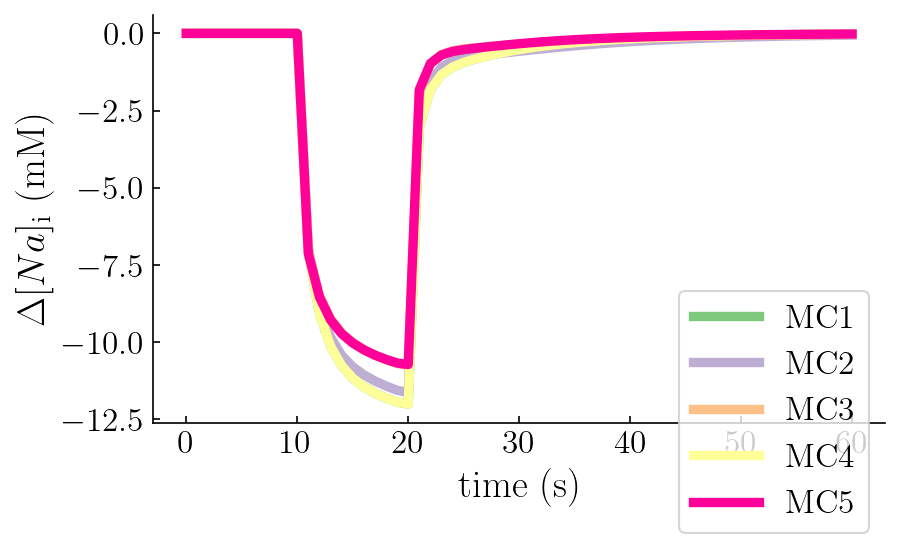

In [61]:
fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list):
    plt.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plot_list) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.4), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## If you want to save the figure
Change the figure name below.

In [50]:
figname = 'Nae_timeplot'

In [51]:
fig.savefig('results/figures/' + figname, dpi='figure', bbox_inches='tight')

## Spaceplots and water velocity!
Add the plots you want to the list and the corresponding x and y labels. The spacedata is setup as $d[k]\_i$ for all the ions and $dp\_m$. The rest have $\_space$ such as $phi\_m\_space$, $j\_in\_space$ and $dalpha\_e\_space$.

The water velocities are saved as $u\_i/e\_hyd/osm/tot$. For example, you can plot MC1.u_i_osm

In [62]:
plotlist = [MC1.dNa_e, MC2.dNa_e, MC3.dNa_e, MC4.dNa_e, MC5.dNa_e]
ylabel = r'$\Delta [k]_\mathrm{e}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

Text(0.5, 0, '$x$ (um)')

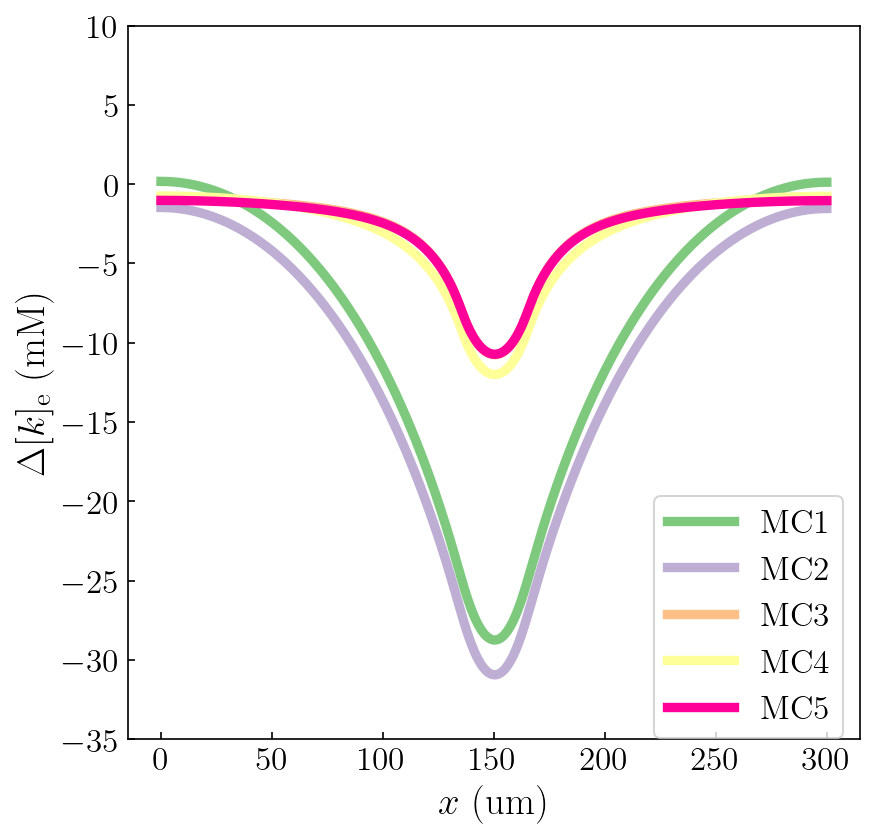

In [63]:
fig = plt.figure(figsize=(7*fs, 7*fs))
ax = plt.gca()
for i, line in enumerate(plotlist):
    df.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plotlist) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.4), frameon=True)
plt.ylim([-35, 10])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

In [64]:
figname = 'Na_e_spaceplots'
fig.savefig('results/figures/' + figname, dpi='figure', bbox_inches='tight')